In [ ]:
!pip install sastrawi wordcloud transformers tqdm seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 726.4 kB/s eta 0:00:00


In [ ]:
# =============================
# Mount Google Drive
# =============================
from google.colab import drive

# =============================
# Built-in / Standard Libraries
# =============================
import re
import json
from collections import Counter

# =============================
# Data Manipulation
# =============================
import pandas as pd
import numpy as np

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# =============================
# Text Preprocessing (Bahasa Indonesia)
# =============================
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# =============================
# Machine Learning
# =============================
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =============================
# Deep Learning - TensorFlow / Keras
# =============================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# =============================
# Deep Learning - Transformers (HuggingFace)
# =============================
import torch
from transformers import AutoTokenizer, AutoModel, pipeline



from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# **Model**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load embeddings dan label dari folder
train_embeddings = np.load('/content/drive/MyDrive/pdm_metopen_uas/embeddings/train_embeddings.npy')
val_embeddings = np.load('/content/drive/MyDrive/pdm_metopen_uas/embeddings/val_embeddings.npy')
test_embeddings = np.load('/content/drive/MyDrive/pdm_metopen_uas/embeddings/test_embeddings.npy')

train_labels = np.load('/content/drive/MyDrive/pdm_metopen_uas/encoding/train_labels.npy')
val_labels = np.load('/content/drive/MyDrive/pdm_metopen_uas/encoding/val_labels.npy')
test_labels = np.load('/content/drive/MyDrive/pdm_metopen_uas/encoding/test_labels.npy')

Mounted at /content/drive


In [ ]:
# Cek bentuk data
print("train embeddings shape:", train_embeddings.shape)
print("train labels shape:", train_labels.shape)

print("val embeddings shape:", val_embeddings.shape)
print("val labels shape:", val_labels.shape)

print("test embeddings shape:", test_embeddings.shape)
print("test labels shape:", test_labels.shape)

train embeddings shape: (5099, 128, 768)
train labels shape: (5099, 3)
val embeddings shape: (1093, 128, 768)
val labels shape: (1093, 3)
test embeddings shape: (1093, 128, 768)
test labels shape: (1093, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.regularizers import l2
import numpy as np

In [ ]:
# 1. Mendefinisikan Arsitektur Model
# ------------------------------------
# Input layer disesuaikan dengan shape embedding Anda: (panjang_sekuens, dimensi_embedding)
input_layer = Input(shape=(128, 768), name='input_layer')

# Convolutional Layer untuk ekstraksi fitur lokal [cite: 14]
# Menggunakan filter dan aktivasi seperti pada referensi [cite: 177]
conv_layer = Conv1D(filters=96, kernel_size=3, activation='relu', name='conv1d_layer')(input_layer)

# MaxPooling Layer untuk mengurangi dimensi dan risiko overfitting [cite: 178]
pooling_layer = MaxPooling1D(pool_size=2, name='maxpooling1d_layer')(conv_layer)
pooling_layer = Dropout(0.5, name='dropout_after_cnn')(pooling_layer) # Dropout 0.5 terbukti optimal

# Bi-LSTM Layer untuk memahami konteks sekuensial [cite: 14]
# Menggunakan 32 unit yang merupakan nilai terbaik pada referensi [cite: 17]
bilstm_layer = Bidirectional(LSTM(units=32, return_sequences=False, kernel_regularizer=l2(0.01)), name='bidirectional_lstm')(pooling_layer) # L2 regularizer meningkatkan generalisasi [cite: 262]
bilstm_layer = Dropout(0.5, name='dropout_after_bilstm')(bilstm_layer)

# Dense Layer sebelum output
dense_layer = Dense(96, activation='relu', name='dense_layer')(bilstm_layer)
dense_layer = Dropout(0.5, name='dropout_after_dense')(dense_layer)

# Output Layer dengan aktivasi softmax untuk klasifikasi multikelas
output_layer = Dense(3, activation='softmax', name='output_layer')(dense_layer)

# Menggabungkan semua layer menjadi sebuah model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# 2. Kompilasi Model
# -------------------
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Cocok untuk label one-hot encoding
              metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer (Conv1D)           │ (None, 126, 96)        │       221,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling1d_layer              │ (None, 63, 96)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_after_cnn (Dropout)     │ (None, 63, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 64)             │        33,024 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_after_bilstm (Dropout)  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_after_dense (Dropout)   │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,835 (1018.89 KB)

 Trainable params: 260,835 (1018.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. Training Model
# ------------------
print("\nMemulai proses training model...")
history = model.fit(train_embeddings, train_labels,
                    epochs=20, # Anda bisa sesuaikan jumlah epoch
                    batch_size=32,
                    validation_data=(val_embeddings, val_labels))

print("Training selesai.")


Memulai proses training model...
Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 224ms/step - accuracy: 0.7084 - loss: 2.1795 - val_accuracy: 0.9195 - val_loss: 0.7230
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.9069 - loss: 0.6736 - val_accuracy: 0.9341 - val_loss: 0.4221
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9314 - loss: 0.4125 - val_accuracy: 0.9360 - val_loss: 0.3112
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9351 - loss: 0.3203 - val_accuracy: 0.9323 - val_loss: 0.2866
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.9417 - loss: 0.2571 - val_accuracy: 0.9360 - val_loss: 0.2404
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - accuracy: 0.9509 - loss: 0.2220 - val_accuracy: 0.9323 - val_loss: 0.2564
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 45s 191ms/step - accuracy: 0.9526 - loss: 0.1865 - val_accuracy: 0.9350 - val_loss: 0.2265
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms

In [ ]:
# 4. Evaluasi Model
# ------------------
print("\nMemulai evaluasi model pada data tes...")
# Evaluasi menggunakan metrik loss dan akurasi
loss, accuracy = model.evaluate(test_embeddings, test_labels, verbose=0)

print(f"\n--- Hasil Evaluasi ---")
print(f"Test Loss    : {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


Memulai evaluasi model pada data tes...

--- Hasil Evaluasi ---
Test Loss    : 0.2695
Test Accuracy: 93.50%


In [ ]:
# Simpan model hasil training
model.save('/content/drive/MyDrive/pdm_metopen_uas/model/cnn_bilstm_model.keras')

In [ ]:
# evaluasi presisi, recall, dan F1-score dengan sklearn
from sklearn.metrics import classification_report
import numpy as np

# Dapatkan prediksi model dalam bentuk probabilitas
y_pred_proba = model.predict(test_embeddings)

# Ubah probabilitas menjadi label kelas (0, 1, atau 2)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(test_labels, axis=1)

print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_true, y_pred, target_names=['Kelas 0 (e.g., Negatif)', 'Kelas 1 (e.g., Netral)', 'Kelas 2 (e.g., Positif)']))


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

Laporan Klasifikasi Lengkap:
                         precision    recall  f1-score   support

Kelas 0 (e.g., Negatif)       0.93      0.93      0.93       484
 Kelas 1 (e.g., Netral)       0.00      0.00      0.00         6
Kelas 2 (e.g., Positif)       0.94      0.95      0.94       603

               accuracy                           0.94      1093
              macro avg       0.62      0.63      0.62      1093
           weighted avg       0.93      0.94      0.93      1093



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


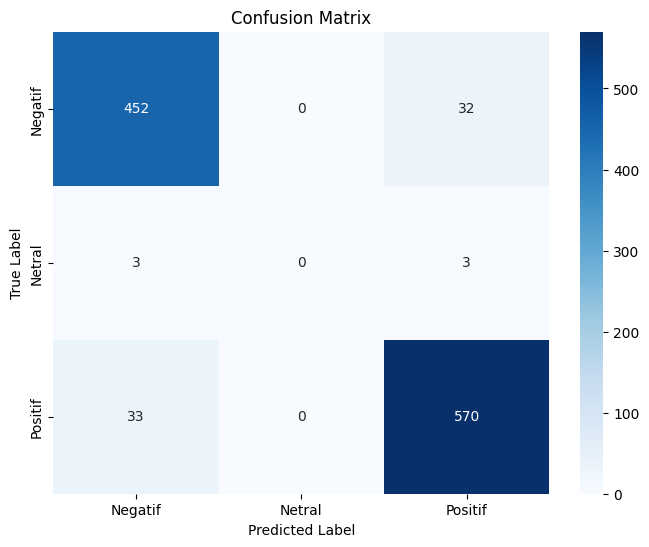

In [ ]:
# Import library yang dibutuhkan
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Membuat visualisasi heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

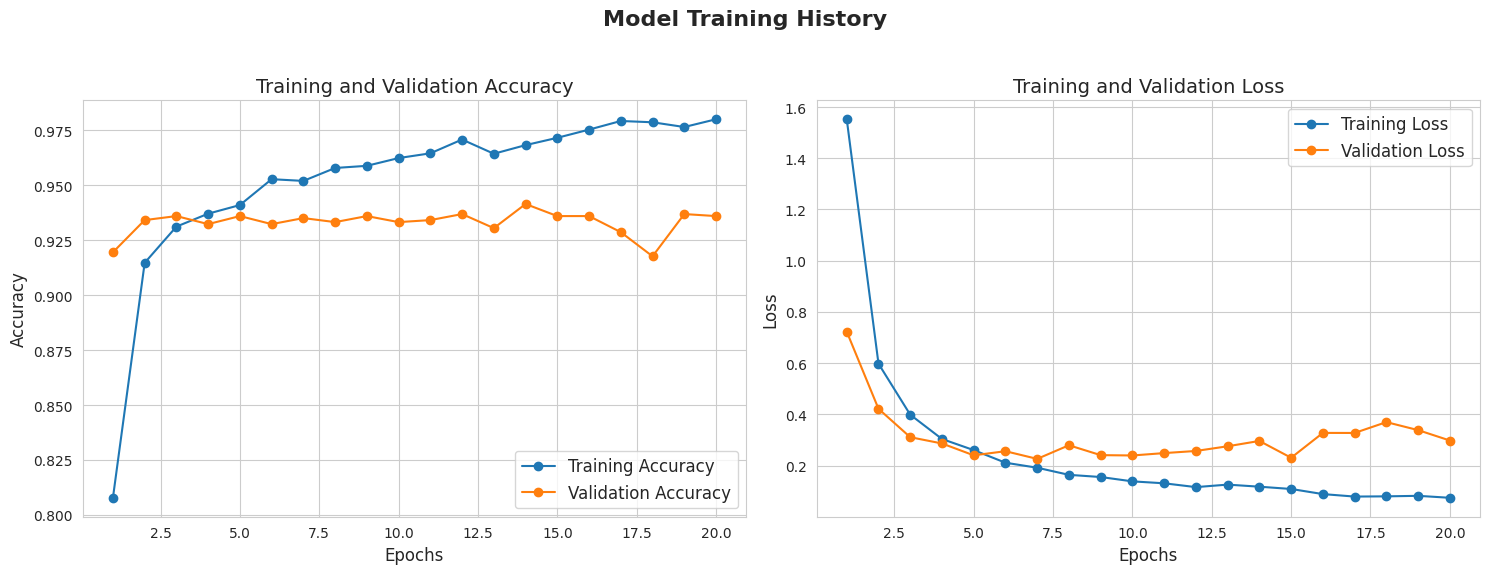

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur style grafik agar terlihat lebih modern
sns.set_style('whitegrid')

# Mengambil data dari variabel 'history' hasil model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat rentang jumlah epoch
epochs_range = range(1, len(acc) + 1)

# Membuat figure dan axes untuk dua subplot (1 baris, 2 kolom)
plt.figure(figsize=(15, 6))

# Subplot 1: Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', linestyle='-')
plt.legend(loc='lower right', fontsize='large')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)

# Subplot 2: Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', linestyle='-')
plt.legend(loc='upper right', fontsize='large')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)

# Menampilkan grafik
plt.suptitle('Model Training History', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Menyesuaikan layout agar suptitle tidak tumpang tindih
plt.show()